## Assignment 1: Language Modeling

*This assignment is adapted from one created by David Gaddy, Daniel Fried, Nikita Kitaev, Mitchell Stern, Rodolfo Corona, John DeNero, and Dan Klein.*

TA contact for this assignment: Saahas Parise (saahas.parise@duke.edu),
Xinchang Xiong (xinchang.xiong@duke.edu)


---



In this assignment, you will implement several different types of language models for text.  We'll start with n-gram models, then move on to neural n-gram and GRU language models.

**Warning**: Do not start this project the day before it is due!  Some parts require 20 minutes or more to run, so debugging and tuning can take a significant amount of time.

Our dataset for this project will be the WikiText2 language modeling dataset.  This dataset comes with some of the basic preprocessing done for us, such as tokenization and rare word filtering (using the `<unk>` token).
Therefore, we can assume that all word types in the test set also appear at least once in the training set.
We'll also use the Huggingface `datasets` and `tokenizers` libraries to help with some of the data preprocessing, such as converting tokens into id numbers.

**Note on GPU usage**: You will need to use a GPU for the neural n-gram and GRU models but **not** for the n-gram models. Colab places some restrictions on GPU usage due to which you might get locked out after continuously using one (~8 hours). To avoid this, you should only use the GPU when needed, i.e., on training and inference for the last two parts of this assignment. You can enable / disable GPU usage by changing the Runtime type under the Runtime menu.
If you do get locked out of using a GPU, a potential workaround is to sign in using a different account.

When training a model on the GPU it is also a good idea to save your model periodically in case you get locked out. You can use `torch.save(network.state_dict(), path)` and `network.load_state_dict()` for this; see [here](https://pytorch.org/tutorials/recipes/recipes/saving_and_loading_models_for_inference.html). You can also save your `*.npy` files to google drive to avoid lossing them after Colab session cut-off (see the sample script below).

```
from google.colab import drive
drive.mount('/content/drive')

!mkdir -p /content/drive/MyDrive/CS572-S24-A1
!cp *.npy /content/drive/MyDrive/CS572-S24-A1
!ls /content/drive/MyDrive/CS572-S24-A1
```

**Grading rubric**
- 70% results
 - 15% bigram_predictions.npy (correctness)
 - 15% trigram_kn_predictions.npy (correctness)
 - 15% neural_trigram_predictions.npy (meets target)
 - 15% gru_predictions.npy (meets target)
 - 10% gru_predictions.npy (improvement over target)
  
- 30% writeup
 - 12.5% clarity
 - 12.5% correctness
 - 5% interestingness of ideas

In [30]:
# Install some required packages.
!pip install transformers
!pip install datasets
!pip install gdown

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


Defaulting to user installation because normal site-packages is not writeable
Looking in indexes: https://pypi.org/simple, https://pypi.ngc.nvidia.com

[notice] A new release of pip is available: 24.0 -> 25.0.1
[notice] To update, run: python3 -m pip install --upgrade pip


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


Defaulting to user installation because normal site-packages is not writeable
Looking in indexes: https://pypi.org/simple, https://pypi.ngc.nvidia.com

[notice] A new release of pip is available: 24.0 -> 25.0.1
[notice] To update, run: python3 -m pip install --upgrade pip


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


Defaulting to user installation because normal site-packages is not writeable
Looking in indexes: https://pypi.org/simple, https://pypi.ngc.nvidia.com

[notice] A new release of pip is available: 24.0 -> 25.0.1
[notice] To update, run: python3 -m pip install --upgrade pip


In [31]:
# This block handles some basic setup and data loading.
# You shouldn't need to edit this, but if you want to
# import other standard python packages, that is fine.

from collections import defaultdict, Counter
import numpy as np
import math
# import tqdm
from tqdm.notebook import tqdm
import random
import pdb

import torch
from torch import nn
import torch.nn.functional as F

# We'll use HuggingFace's datasets and tokenizers libraries, which are a bit
# heavy-duty for what we're doing, but it's worth getting to know them.

from datasets import load_dataset
from tokenizers import Tokenizer
from tokenizers.models import WordLevel
from tokenizers.trainers import WordLevelTrainer
from tokenizers.pre_tokenizers import WhitespaceSplit

dataset = load_dataset("wikitext", "wikitext-2-v1")
tokenizer = Tokenizer(WordLevel(unk_token='<unk>'))
tokenizer.pre_tokenizer = WhitespaceSplit() # should be equivalent to split()

# "Training" a tokenizer below just feeds it all the tokens so it can map from
# word type to id.

trainer = WordLevelTrainer( # should only be 33,278 distinct types in Wikitext-2
    vocab_size=33300, special_tokens=["<unk>", "<eos>"])
generator_bsz = 512
all_splits_generator = (dataset[split][i:i+generator_bsz]["text"]
                        for split in ["train", "validation", "test"]
                          for i in range (0, len(dataset[split]), generator_bsz))
tokenizer.train_from_iterator(all_splits_generator, trainer)

# If desired, we could make a transformers tokenizer object now with:
# fast_tokenizer = PreTrainedTokenizerFast(tokenizer_object=tokenizer)

orig_vocab = tokenizer.get_vocab() # The tokenizer reserves a <pad> id, which we'll ignore.
word_types = sorted(list(orig_vocab.keys()), key=lambda w: orig_vocab[w]) # no <pad>
vocab = {w: i for i, w in enumerate(word_types)} # no <pad>
vocab_size = len(vocab)

# Make a single stream of tokens, with an <eos> after each newline.

train_text = []
for example in dataset["train"]["text"]:
  train_text.extend(tokenizer.encode(example).tokens + ["<eos>"])

validation_text = []
for example in dataset["validation"]["text"]:
  validation_text.extend(tokenizer.encode(example).tokens + ["<eos>"])

print(validation_text[:30])

['<eos>', '=', 'Homarus', 'gammarus', '=', '<eos>', '<eos>', 'Homarus', 'gammarus', ',', 'known', 'as', 'the', 'European', 'lobster', 'or', 'common', 'lobster', ',', 'is', 'a', 'species', 'of', '<unk>', 'lobster', 'from', 'the', 'eastern', 'Atlantic', 'Ocean']


We've implemented a unigram model here as a demonstration.

In [32]:
class UnigramModel:
    def __init__(self, train_text):
        self.counts = Counter(train_text)
        self.total_count = len(train_text)

    def probability(self, word):
        return self.counts[word] / self.total_count

    def next_word_probabilities(self, text_prefix):
        """Return a list of probabilities for each word in the vocabulary."""
        return [self.probability(word) for word in word_types]

    def perplexity(self, full_text):
        """Return the perplexity of the model on a text as a float.

        full_text -- a list of string tokens
        """
        log_probabilities = []
        for word in full_text:
            # Note that the base of the log doesn't matter
            # as long as the log and exp use the same base.
            log_probabilities.append(math.log(self.probability(word), 2))
        return 2 ** -np.mean(log_probabilities)

unigram_demonstration_model = UnigramModel(train_text)
print('unigram validation perplexity:',
      unigram_demonstration_model.perplexity(validation_text))

def check_validity(model):
    """Performs several sanity checks on your model:
    1) That next_word_probabilities returns a valid distribution
    2) That perplexity matches a perplexity calculated from next_word_probabilities

    Although it is possible to calculate perplexity from next_word_probabilities,
    it is still good to have a separate more efficient method that only computes
    the probabilities of observed words.
    """

    log_probabilities = []
    for i in range(10):
        prefix = validation_text[:i]
        probs = model.next_word_probabilities(prefix)
        assert min(probs) >= 0, "Negative value in next_word_probabilities"
        assert max(probs) <= 1 + 1e-8, "Value larger than 1 in next_word_probabilities"
        assert abs(sum(probs)-1) < 1e-4, "next_word_probabilities do not sum to 1"

        word_id = vocab[validation_text[i]]
        selected_prob = probs[word_id]
        log_probabilities.append(math.log(selected_prob))

    perplexity = math.exp(-np.mean(log_probabilities))
    your_perplexity = model.perplexity(validation_text[:10])
    assert abs(perplexity-your_perplexity) < 0.1, "your perplexity does not " + \
    "match the one we calculated from `next_word_probabilities`,\n" + \
    "at least one of `perplexity` or `next_word_probabilities` is incorrect.\n" + \
    f"we calcuated {perplexity} from `next_word_probabilities`,\n" + \
    f"but your perplexity function returned {your_perplexity} (on a small sample)."


check_validity(unigram_demonstration_model)

unigram validation perplexity: 965.0860734119312


To generate from a language model, we can sample one word at a time conditioning on the words we have generated so far.

In [33]:
def generate_text(model, n=20, prefix=('<eos>', '<eos>')):
    prefix = list(prefix)
    for _ in range(n):
        probs = model.next_word_probabilities(prefix)
        word = random.choices(word_types, probs)[0]
        prefix.append(word)
    return ' '.join(prefix)

print(generate_text(unigram_demonstration_model))

<eos> <eos> <unk> ) State light the <eos> Americans pathos Adults the rises double its whether On be in ( recorded and


In fact there are many strategies to get better-sounding samples, such as only sampling from the top-k words or sharpening the distribution with a temperature.  You can read more about sampling from a language model in this paper: https://arxiv.org/pdf/1904.09751.pdf.

You will need to submit some outputs from the models you implement for us to grade.  The following will download the required output files.

In [34]:
!gdown --id 1aHC9RfmeSa8dDwC9XGQN8uRmtTwJaIRw
!gdown --id 1oedI437UeS9AhUGwsC-PgBdD1sHOjhaY

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


/usr/local/lib/python3.10/dist-packages/gdown/__main__.py:132: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  warnings.warn(
Downloading...
From: https://drive.google.com/uc?id=1aHC9RfmeSa8dDwC9XGQN8uRmtTwJaIRw
To: /storage/ice1/3/4/pponnusamy7/nu_eval_output_vocab_short.txt
100%|██████████████████████████████████████| 3.67k/3.67k [00:00<00:00, 49.5MB/s]


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


/usr/local/lib/python3.10/dist-packages/gdown/__main__.py:132: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  warnings.warn(
Downloading...
From: https://drive.google.com/uc?id=1oedI437UeS9AhUGwsC-PgBdD1sHOjhaY
To: /storage/ice1/3/4/pponnusamy7/nu_eval_prefixes_short.txt
100%|████████████████████████████████████████| 104k/104k [00:00<00:00, 25.0MB/s]


In [35]:
def save_truncated_distribution(model, filename, short=True):
    """Generate a file of truncated distributions.

    Probability distributions over the full vocabulary are large,
    so we will truncate the distribution to a smaller vocabulary.

    Please do not edit this function
    """
    vocab_name = 'nu_eval_output_vocab'
    prefixes_name = 'nu_eval_prefixes'

    if short:
      vocab_name += '_short'
      prefixes_name += '_short'

    with open('{}.txt'.format(vocab_name), 'r') as eval_vocab_file:
        eval_vocab = [w.strip() for w in eval_vocab_file]
    eval_vocab_ids = [vocab[s] for s in eval_vocab]

    all_selected_probabilities = []
    with open('{}.txt'.format(prefixes_name), 'r') as eval_prefixes_file:
        lines = eval_prefixes_file.readlines()
        for line in tqdm(lines, leave=False):
            prefix = line.strip().split(' ')
            probs = model.next_word_probabilities(prefix)
            selected_probs = np.array([probs[i] for i in eval_vocab_ids], dtype=np.float32)
            all_selected_probabilities.append(selected_probs)

    all_selected_probabilities = np.stack(all_selected_probabilities)
    np.save(filename, all_selected_probabilities)
    print('saved', filename)

In [36]:
save_truncated_distribution(unigram_demonstration_model,
                            'unigram_demonstration_predictions.npy')

  0%|          | 0/1000 [00:00<?, ?it/s]

saved unigram_demonstration_predictions.npy


**Before you proceed**: At this point you should check whether you are able to upload the submission files to Gradescope. For this we will generate *dummy* prediction files by copying the unigram predictions above. Download the `unigrm_demonstration_predictions.npy` (you can do this by clicking the folder icon on left menu) and then copy this file and rename it to generate the required submision files:
* bigram_predictions.npy
* trigram_kn_predictions.npy
* neural_trigram_predictions.npy
* gru_predictions.npy

Also save a copy of this notebook as `proj_1.ipynb` and create a `report.pdf` (this can be empty for now). Upload these files to Gradescope and confirm that the autograder runs and produces an output score of 0.

### N-gram Model

Now it's time to implement an n-gram language model.

Alright great! let's do this :)

Because not every n-gram will have been observed in training, use add-alpha smoothing to make sure no output word has probability 0.

$$P(w_2|w_1)=\frac{\#(w_1,w_2)+\alpha}{\#(w_1)+V\alpha}$$

where $V$ is the vocab size and $\#()$ is the count for the given bigram.  An alpha value around `3e-3`  should work.  Later, we'll replace this smoothing with model backoff.

One edge case you will need to handle is at the beginning of the text where you don't have `n-1` prior words.  You can handle this however you like as long as you produce a valid probability distribution, but just using a uniform distribution over the vocabulary is reasonable for the purposes of this project.

A properly implemented bi-gram model should get a perplexity **below 505** on the validation set.

**Note**: Do not change the signature of the `next_word_probabilities` and `perplexity` functions.  We will use these as a common interface for all of the different model types.  Make sure these two functions call `n_gram_probability`, because later we are going to override `n_gram_probability` in a subclass.
Also, we suggest pre-computing and caching the counts $\#()$ when you initialize `NGramModel` for efficiency.

In [37]:
class NGramModel:
    def __init__(self, train_text, n=2, alpha=3e-3):
        self.n = n
        self.alpha = alpha
        self.vocab_size = len(vocab)


        self.ngram_counts = Counter()

        self.prefix_counts = Counter()

        # Populate counts
        for i in range(len(train_text)):
            # Build an n-gram prefix
            prefix_tokens = []
            # We go from i-(n-1) to i-1 (inclusive)
            for j in range(self.n - 1):
                idx = i - (self.n - 1) + j
                # If idx < 0, maybe use <eos> or break - could do padding too but eos makes more sense
                if idx < 0:
                    prefix_tokens.append('<eos>')
                else:
                    prefix_tokens.append(train_text[idx])

            prefix = tuple(prefix_tokens)
            current_word = train_text[i]

            self.ngram_counts[prefix + (current_word,)] += 1
            self.prefix_counts[prefix] += 1

    def n_gram_probability(self, n_gram):
        """
        n_gram is a tuple/list of length self.n
        Return P( last_word | first_(n-1)_words ).
        """
        prefix = tuple(n_gram[:-1])
        word = n_gram[-1]
        numerator = self.ngram_counts[n_gram] + self.alpha # we are adding the alpha smoothing here
        denominator = self.prefix_counts[prefix] + self.alpha * self.vocab_size # we have to now normalize by all of alpha smoothing
        return numerator / denominator

    def next_word_probabilities(self, text_prefix):
        # Build the last (n-1) words of the prefix
        # If text_prefix < n-1 tokens, pad with <eos> or handle as needed
        prefix_tokens = []
        for j in range(self.n - 1):
            idx = len(text_prefix) - (self.n - 1) + j
            if idx < 0:
                prefix_tokens.append('<eos>')
            else:
                prefix_tokens.append(text_prefix[idx])
        prefix = tuple(prefix_tokens)

        # Probability for each word in the vocabulary
        probs = []
        for w in word_types:
            probs.append(self.n_gram_probability(prefix + (w,)))

        # Convert to a proper distribution
        # (They should already sum to ~1 with add-alpha smoothing, but minor float
        # rounding is OK.)
        return probs

    def perplexity(self, full_text):
        # We compute average negative log2 probability
        log_probs = []
        for i in range(len(full_text)):
            # build the ngram
            prefix_tokens = []
            for j in range(self.n - 1):
                idx = i - (self.n - 1) + j
                if idx < 0:
                    prefix_tokens.append('<eos>')
                else:
                    prefix_tokens.append(full_text[idx])
            prefix = tuple(prefix_tokens)
            word = full_text[i]

            p = self.n_gram_probability(prefix + (word,))
            log_probs.append(math.log2(p))

        avg_log_prob = sum(log_probs) / len(log_probs)
        perp = 2 ** (-avg_log_prob)
        return perp


unigram_model = NGramModel(train_text, n=1)
check_validity(unigram_model)
print('unigram validation perplexity:', unigram_model.perplexity(validation_text)) # this should be the almost the same as our unigram model perplexity above

bigram_model = NGramModel(train_text, n=2)
check_validity(bigram_model)
print('bigram validation perplexity:', bigram_model.perplexity(validation_text))

trigram_model = NGramModel(train_text, n=3)
check_validity(trigram_model)
print('trigram validation perplexity:', trigram_model.perplexity(validation_text)) # this won't do very well...

save_truncated_distribution(bigram_model, 'bigram_predictions.npy') # this might take a few minutes

unigram validation perplexity: 965.0913672704497
bigram validation perplexity: 504.40436062976
trigram validation perplexity: 2965.3608021772866


  0%|          | 0/1000 [00:00<?, ?it/s]

saved bigram_predictions.npy



Please download `bigram_predictions.npy` once you finish this section so that you can submit it.

In the block below, please report your bigram validation perplexity.  (We will use this to help us calibrate our scoring on the test set.)

<!-- Do not remove this comment, it is used by the autograder: RqYJKsoTS6 -->

Bigram validation perplexity: 504

We can also generate samples from the model to get an idea of how it is doing.

In [38]:
print(generate_text(bigram_model))

<eos> <eos> Antimony VI cheerleader Graves Raeburn Bormanis Agnes Cautionary Rysher lectures molecule judgment pilots Kids 5A Ducks opportunities differentiate showdown foul


We now free up some RAM, **it is important to run the cell below, otherwise you will likely run out of RAM in the Colab runtime.**

In [39]:
# Free up some RAM.
del bigram_model
del trigram_model

This basic model works okay for bigrams, but a better strategy (especially for higher-order models) is to use backoff.  Implement backoff with absolute discounting.
$$P\left(w_i|h_i\right)=\frac{max\left\{\#(h_i, w_i)-d,0\right\}}{\#(h_i)} + \lambda(h_i) P(w_i|w_{i-n+2},\ldots, w_{i-1})$$

$$\lambda\left(h_i\right)=\frac{d N_{1+}(h_i)}{{\#(h_i)}}$$
where $h_i=(w_{i-n+1}, \ldots, w_{i-1})$ is the prefix before token $i$, $N_{1+}$ is the number of words that appear after the previous $n-1$ words (the number of times the max will select something other than 0 in the first equation).  If $\#(h_i)=0$, use the lower order model probability directly (the above equations would have a division by 0).

We found a discount $d$ of 0.9 to work well based on validation performance.  A trigram model with this discount value should get a validation perplexity below 272.

In [40]:
class DiscountBackoffModel(NGramModel):
    def __init__(self, train_text, lower_order_model, n=2, delta=0.9):
        super().__init__(train_text, n=n, alpha=0.0)  # see we don't need an alpha since we are discounting
        self.lower_order_model = lower_order_model
        self.discount = delta

        self.unique_continuations = Counter()
        self.continuations_by_prefix = defaultdict(set)
        for key, c in self.ngram_counts.items():
            prefix = key[:-1]  # get the prefix (all elements except the last)
            word = key[-1]     # get the last word
            self.continuations_by_prefix[prefix].add(word)

        for prefix, words in self.continuations_by_prefix.items():
            self.unique_continuations[prefix] = len(words)

    def n_gram_probability(self, n_gram):
        prefix = n_gram[:-1]
        word = n_gram[-1]

        prefix_count = self.prefix_counts[prefix]
        if prefix_count == 0:
            # If we haven't seen the prefix at all, back off entirely
            return self.lower_order_model.n_gram_probability(n_gram[1:])

        count_ngram = self.ngram_counts[n_gram]
        # Apply discounting - we can currently keep self.discount to be as given:
        discounted_count = max(count_ngram - self.discount, 0)

        lambda_h = (self.discount * self.unique_continuations[prefix]) / prefix_count

        p_lower = self.lower_order_model.n_gram_probability(n_gram[1:])
        p = discounted_count / prefix_count + lambda_h * p_lower
        return p



bigram_backoff_model = DiscountBackoffModel(train_text, unigram_model, 2)
trigram_backoff_model = DiscountBackoffModel(train_text, bigram_backoff_model, 3)
check_validity(trigram_backoff_model)
print('trigram backoff validation perplexity:', trigram_backoff_model.perplexity(validation_text))

trigram backoff validation perplexity: 271.0992281148029


Yes! Indeed the validation perplexity with backoff and discounting is 271 :)

Free up RAM.

In [41]:
# Release models we don't need any more.
del unigram_model
del bigram_backoff_model
del trigram_backoff_model

Now, implement Kneser-Ney to replace the unigram base model.
$$P(w)\propto |\{w':\#(w',w) > 0\}|$$
A Kneser-Ney trigram model should get a validation perplexity below 257.

In [42]:
class KneserNeyBaseModel(NGramModel):
    def __init__(self, train_text):
        super().__init__(train_text, n=1, alpha=0.0)
        self.num_distinct_preceders = Counter()

        distinct_preceders_map = defaultdict(set)
        for i in range(1, len(train_text)):
            w_prev = train_text[i-1]
            w_cur = train_text[i]
            distinct_preceders_map[w_cur].add(w_prev)

        for w, distinct_set in distinct_preceders_map.items():
            self.num_distinct_preceders[w] = len(distinct_set)

        self.total_distinct_preceders = sum(self.num_distinct_preceders.values())

    def n_gram_probability(self, n_gram):
        w = n_gram[0]
        return self.num_distinct_preceders[w] / self.total_distinct_preceders


kn_base = KneserNeyBaseModel(train_text)
check_validity(kn_base)
bigram_kn_backoff_model = DiscountBackoffModel(train_text, kn_base, 2)
trigram_kn_backoff_model = DiscountBackoffModel(train_text, bigram_kn_backoff_model, 3)
print('trigram Kneser-Ney backoff validation perplexity:', trigram_kn_backoff_model.perplexity(validation_text))

save_truncated_distribution(trigram_kn_backoff_model, 'trigram_kn_predictions.npy') # this might take a few minutes

trigram Kneser-Ney backoff validation perplexity: 256.59210020005014


  0%|          | 0/1000 [00:00<?, ?it/s]

saved trigram_kn_predictions.npy


In [43]:
print(generate_text(trigram_kn_backoff_model))
print(generate_text(trigram_kn_backoff_model, prefix=['What','about']))

<eos> <eos> On 14 , and his wife , which contained Shiban الله central Siberia , the world . <eos> <eos> The
What about half that turned into a radio runaway bride who reunites with nuclei , growing lost disconcerting . It is unclear


Fill in your trigram backoff perplexities with and without Kneser Ney.

<!-- Do not remove this comment, it is used by the autograder: RqYJKsoTS6 -->

Trigram backoff validation perplexity: 271.0992281148029

Trigram backoff with Kneser Ney perplexity: 256.59210020005014

Free up RAM.

In [44]:
# Delete models we don't need.
del kn_base
del bigram_kn_backoff_model
del trigram_kn_backoff_model

### Neural N-gram Model

In this section, you will implement a neural version of an n-gram model.  The model will use a simple feedforward neural network that takes the previous `n-1` words and outputs a distribution over the next word.

You will use PyTorch to implement the model.  We've provided a little bit of code to help with the data loading using PyTorch's data loaders (https://pytorch.org/docs/stable/data.html)

A model with the following architecture and hyperparameters should reach a validation perplexity **below or about 220**.
* embed the words with dimension 128, then flatten into a single embedding for $n-1$ words (with size $(n-1)*128$)
* run 2 hidden layers with 1024 hidden units, then project down to size 128 before the final layer (ie. 4 layers total).
* use weight tying for the embedding and final linear layer (this made a very large difference in our experiments); you can do this by creating the output layer with [`nn.Linear`](https://pytorch.org/docs/stable/generated/torch.nn.Linear.html), then using [`F.embedding`](https://pytorch.org/docs/stable/generated/torch.nn.functional.embedding.html) with the linear layer's `.weight` to embed the input
* rectified linear activation (ReLU) and dropout 0.1 after first 2 hidden layers. **Note: You will likely find a performance drop if you add a nonlinear activation function after the dimension reduction layer.**
* train for 10 epochs with the Adam optimizer (should take around 15-20 minutes)
* do early stopping based on validation set perplexity (see Project 0)


We encourage you to try other architectures and hyperparameters, and you will likely find some that work better than the ones listed above.  A proper implementation with these should be enough to receive full credit on the assignment, although you might need to retrain the model for a few time.

In [45]:
import torch.optim as optim
import torch.nn.functional as F

def ids(tokens):
    return [vocab[t] for t in tokens]

# assert torch.cuda.is_available(), "no GPU found, in Colab go to 'Edit->Notebook settings' and choose a GPU hardware accelerator"

device = torch.device("cuda")
print("Using device:", device)

class NeuralNgramDataset(torch.utils.data.Dataset):
    def __init__(self, text_token_ids, n):
        self.text_token_ids = text_token_ids
        self.n = n

    def __len__(self):
        return len(self.text_token_ids)

    def __getitem__(self, i):
        if i < self.n-1:
            prev_token_ids = [vocab['<eos>']] * (self.n-i-1) + self.text_token_ids[:i]
        else:
            prev_token_ids = self.text_token_ids[i-self.n+1:i]

        assert len(prev_token_ids) == self.n-1

        x = torch.tensor(prev_token_ids)
        y = torch.tensor(self.text_token_ids[i])
        return x, y

class NeuralNGramNetwork(nn.Module):
    def __init__(self, n):
        super().__init__()
        self.n = n

        self.vocab_size = len(vocab)
        self.embed_size = 128
        self.hidden_size = 1024


        self.out_layer = nn.Linear(self.embed_size, self.vocab_size, bias=True)

        self.fc1 = nn.Linear((n - 1) * self.embed_size, self.hidden_size)
        self.fc2 = nn.Linear(self.hidden_size, self.hidden_size)
        self.fc3 = nn.Linear(self.hidden_size, self.embed_size)

        self.dropout1 = nn.Dropout(0.1)
        self.dropout2 = nn.Dropout(0.1)

    def forward(self, x):
        """
        x has shape (batch, n-1).
        Return log-probabilities of shape (batch, vocab_size).
        """
        batch_size = x.size(0)

        embedded = F.embedding(x, self.out_layer.weight)

        # (2) Flatten => (batch, (n-1)*embed_size)
        embedded = embedded.view(batch_size, -1)

        # (3) hidden layer #1
        h1 = self.fc1(embedded)
        h1 = F.relu(h1)
        h1 = self.dropout1(h1)

        # (4) hidden layer #2
        h2 = self.fc2(h1)
        h2 = F.relu(h2)
        h2 = self.dropout2(h2)

        # (5) dimension reduction
        h3 = self.fc3(h2)
        # optionally a ReLU here, but many find skipping it helps

        # (6) output projection
        # shape => (batch, vocab_size)
        logits = self.out_layer(h3)

        # (7) convert to log probs
        log_probs = F.log_softmax(logits, dim=-1)
        return log_probs


class NeuralNGramModel:
    def __init__(self, n):
        self.n = n
        self.network = NeuralNGramNetwork(n).to(device)

    def train(self, n_epochs=10):
        dataset = NeuralNgramDataset(ids(train_text), self.n)
        train_loader = torch.utils.data.DataLoader(dataset, batch_size=128, shuffle=True)

        optimizer = torch.optim.Adam(self.network.parameters(), lr=1e-3)
        criterion = nn.NLLLoss()  # negative log likelihood

        best_val_ppl = 1e9
        for epoch in range(n_epochs):
            self.network.train()  # set training mode
            total_loss = 0
            for x, y in tqdm(train_loader):
                x = x.to(device)
                y = y.to(device)

                optimizer.zero_grad()
                log_probs = self.network(x)  # shape (batch, vocab)
                loss = criterion(log_probs, y)
                loss.backward()
                optimizer.step()

                total_loss += loss.item()

            avg_loss = total_loss / len(train_loader)
            print(f"Epoch {epoch+1} - Training loss: {avg_loss:.4f}")
            val_ppl = self.perplexity(validation_text)
            print(f"Validation Perplexity: {val_ppl:.2f}")

            # Early stopping
            if val_ppl < best_val_ppl:
                best_val_ppl = val_ppl
            else:
                print("No improvement, stopping early.")
                break

    def next_word_probabilities(self, text_prefix):
        self.network.eval()
        with torch.no_grad():
            # Build input for the last n-1 tokens
            prefix_ids = []
            needed = self.n - 1
            # handle short prefix by padding with <eos>
            start_idx = max(0, len(text_prefix) - needed)
            prefix_ids = text_prefix[start_idx:]
            prefix_ids = [vocab[w] for w in prefix_ids]
            if len(prefix_ids) < needed:
                prefix_ids = [vocab['<eos>']]*(needed - len(prefix_ids)) + prefix_ids

            x = torch.tensor(prefix_ids, dtype=torch.long, device=device).unsqueeze(0)  # shape (1, n-1)
            log_probs = self.network(x)  # shape (1, vocab_size)
            probs = log_probs.exp().squeeze(0).cpu().numpy()
            return probs.tolist()

    def perplexity(self, text):
        self.network.eval()
        dataset = NeuralNgramDataset(ids(text), self.n)
        loader = torch.utils.data.DataLoader(dataset, batch_size=128, shuffle=False)
        total_loss = 0
        count = 0
        criterion = nn.NLLLoss(reduction='sum')
        with torch.no_grad():
            for x, y in loader:
                x = x.to(device)
                y = y.to(device)

                log_probs = self.network(x)
                loss = criterion(log_probs, y)
                total_loss += loss.item()
                count += x.size(0)

        # NLL = total_loss / count
        # perplexity = exp(NLL)
        avg_nll = total_loss / count
        ppl = math.exp(avg_nll)
        return ppl


neural_trigram_model = NeuralNGramModel(3)
check_validity(neural_trigram_model)
neural_trigram_model.train()
print('neural trigram validation perplexity:', neural_trigram_model.perplexity(validation_text))

save_truncated_distribution(neural_trigram_model, 'neural_trigram_predictions.npy')

Using device: cuda


  0%|          | 0/16318 [00:00<?, ?it/s]

Epoch 1 - Training loss: 5.8642
Validation Perplexity: 232.71


  0%|          | 0/16318 [00:00<?, ?it/s]

Epoch 2 - Training loss: 5.3639
Validation Perplexity: 212.70


  0%|          | 0/16318 [00:00<?, ?it/s]

Epoch 3 - Training loss: 5.1900
Validation Perplexity: 209.74


  0%|          | 0/16318 [00:00<?, ?it/s]

Epoch 4 - Training loss: 5.0825
Validation Perplexity: 207.67


  0%|          | 0/16318 [00:00<?, ?it/s]

Epoch 5 - Training loss: 5.0064
Validation Perplexity: 212.28
No improvement, stopping early.
neural trigram validation perplexity: 212.28087624701462


  0%|          | 0/1000 [00:00<?, ?it/s]

saved neural_trigram_predictions.npy


Fill in your neural trigram perplexity.

<!-- Do not remove this comment, it is used by the autograder: RqYJKsoTS6 -->

Neural trigram validation perplexity: 207

Free up RAM.

In [46]:
# Delete model we don't need.
del neural_trigram_model

### RNN (GRU) Model

For this stage of the project, you will implement an RNN language model using a popular variant -- [Gated recurrent unit (GRU)](https://en.wikipedia.org/wiki/Gated_recurrent_unit).

For recurrent language modeling, the data batching strategy is a bit different from what is used in some other tasks.  Sentences are concatenated together so that one sentence starts right after the other, and an unfinished sentence will be continued in the next batch.  We have provided a helper class `RecurrentLMDataset` to this for you.  To properly deal with this input format, you should save the last state of the GRU from a batch to feed in as the first state of the next batch.  When you save state across different batches, you should call `.detach()` on the state tensors before the next batch to tell PyTorch not to backpropagate gradients through the state into the batch you have already finished (which will cause a runtime error).

We expect your model to reach a validation perplexity **below 130**.  The following architecture and hyperparameters should be sufficient to get there.
* 2 GRU layers with 768 units
* dropout of 0.5 after each GRU layer and each linear layer (use different dropout modules)
* instead of projecting directly from the last GRU output to the vocabulary size for softmax, project down to a smaller size first (e.g. 768->128->vocab_size). **NOTE: You may find that adding nonlinearities between these layers can hurt performance, try without first.**
* use the same weights for the embedding layer and the pre-softmax layer; dimension 128
* train with Adam (using default learning rates) for at least 10 epochs
* clip gradient norms to be lower than 5 before taking an optimization step (code example below)


In [53]:
import math
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from tqdm.notebook import tqdm

def ids(tokens):
    return [vocab[t] for t in tokens]

if torch.cuda.is_available():
    device = torch.device("cuda")
elif torch.backends.mps.is_available():
    device = torch.device("mps")
else:
    device = torch.device("cpu")
print("Using device:", device)

class RecurrentLMDataset:
    def __init__(self, text_token_ids, bsz, bptt_len=32):
        self.bsz = bsz
        self.bptt_len = bptt_len
        token_ids = torch.tensor(text_token_ids)
        ncontig = token_ids.size(0) // bsz
        token_ids = token_ids[:ncontig*bsz].view(bsz, -1)  # batch_size x ncontig
        self.token_ids = token_ids.t().contiguous()        # ncontig x batch_size

    def __len__(self):
        return int(math.ceil(self.token_ids.size(0) / self.bptt_len))

    def __iter__(self):
        for i in range(0, self.token_ids.size(0)-1, self.bptt_len):
            seqlen = min(self.bptt_len, self.token_ids.size(0) - i - 1)
            x = self.token_ids[i:i+seqlen]    # shape: (seqlen, batch_size)
            y = self.token_ids[i+1:i+seqlen+1]
            yield x, y

# Hyperparameters (unchanged)
batch_size = 64
n_epochs = 15
bptt_len = 32
n_layers = 2
hidden_size = 768
embed_size = 128
clip = 5.0

class GRUNetwork(nn.Module):
    def __init__(self):
        super().__init__()

        self.gru = nn.GRU(
            input_size=embed_size,
            hidden_size=hidden_size,
            num_layers=n_layers,
            dropout=0.5
        )

        self.proj = nn.Linear(hidden_size, embed_size)

        self.dropout = nn.Dropout(0.5)

        self.out = nn.Linear(embed_size, vocab_size, bias=False)

    def forward(self, x, hidden):
        """
        x: (seq_len, batch)
        hidden: (n_layers, batch, hidden_size)
        return: log_probs (seq_len, batch, vocab_size), new_hidden
        """

        emb = F.embedding(x, self.out.weight)  # shape: (seq_len, batch, embed_size)

        output, hidden = self.gru(emb, hidden)    # (seq_len, batch, hidden_size)

        projed = self.proj(output)                # (seq_len, batch, embed_size)
        projed = self.dropout(projed)
        logits = self.out(projed)                 # (seq_len, batch, vocab_size)

        log_probs = F.log_softmax(logits, dim=2)  # (seq_len, batch, vocab_size)
        return log_probs, hidden

class GRUModel:
    def __init__(self):
        self.network = GRUNetwork().to(device)

    def train(self):
        rnn_lm_dataset = RecurrentLMDataset(ids(train_text), batch_size, bptt_len)
        optimizer = optim.Adam(self.network.parameters(), lr=1.25e-3)

        for epoch in range(n_epochs):
            self.network.train()
            hidden = torch.zeros(n_layers, batch_size, hidden_size, device=device)
            total_loss = 0.0
            total_tokens = 0

            for x, y in tqdm(rnn_lm_dataset, leave=False):
                x = x.to(device)
                y = y.to(device)

                optimizer.zero_grad()
                log_probs, hidden = self.network(x, hidden)

                # Detach hidden state to avoid backprop through previous batches
                hidden = hidden.detach()

                seq_len, bsz = x.size()
                # Negative log-likelihood loss (reduction='sum')
                loss = F.nll_loss(
                    log_probs.view(seq_len * bsz, -1),
                    y.view(seq_len * bsz),
                    reduction='sum'
                )
                loss.backward()

                torch.nn.utils.clip_grad_norm_(self.network.parameters(), clip)
                optimizer.step()

                total_loss += loss.item()
                total_tokens += seq_len * bsz

            avg_loss = total_loss / total_tokens
            train_ppl = math.exp(avg_loss)
            val_ppl = self.perplexity(validation_text)
            print(f"Epoch {epoch+1}/{n_epochs} - "
                  f"Train PPL: {train_ppl:.2f}, Val PPL: {val_ppl:.2f}")

    def next_word_probabilities(self, text_prefix):
        self.network.eval()
        with torch.no_grad():
            if len(text_prefix) < 1:
                text_prefix = ['<eos>']
            prefix_ids = [vocab[w] for w in text_prefix]
            x = torch.tensor(prefix_ids, dtype=torch.long, device=device).unsqueeze(1)
            hidden = torch.zeros(n_layers, 1, hidden_size, device=device)
            log_probs, hidden = self.network(x, hidden)
            last_log_probs = log_probs[-1, 0, :]
            probs = torch.exp(last_log_probs)
            return probs.cpu().tolist()

    def perplexity(self, text):
        val_dataset = RecurrentLMDataset(ids(text), batch_size, bptt_len)
        hidden = torch.zeros(n_layers, batch_size, hidden_size, device=device)
        total_loss = 0.0
        total_tokens = 0
        self.network.eval()
        with torch.no_grad():
            for x, y in val_dataset:
                x = x.to(device)
                y = y.to(device)
                log_probs, hidden = self.network(x, hidden)
                hidden = hidden.detach()
                seq_len, bsz = x.size()
                loss = F.nll_loss(
                    log_probs.view(seq_len * bsz, -1),
                    y.view(seq_len * bsz),
                    reduction='sum'
                )
                total_loss += loss.item()
                total_tokens += seq_len * bsz
        avg_loss = total_loss / total_tokens
        return math.exp(avg_loss)

# Training / usage:
gru_model = GRUModel()
gru_model.train()
print('gru validation perplexity:', gru_model.perplexity(validation_text))
save_truncated_distribution(gru_model, 'gru_predictions.npy')


Using device: cuda


  0%|          | 0/1020 [00:00<?, ?it/s]

Epoch 1/15 - Train PPL: 608.95, Val PPL: 276.07


  0%|          | 0/1020 [00:00<?, ?it/s]

Epoch 2/15 - Train PPL: 290.64, Val PPL: 199.21


  0%|          | 0/1020 [00:00<?, ?it/s]

Epoch 3/15 - Train PPL: 214.61, Val PPL: 170.76


  0%|          | 0/1020 [00:00<?, ?it/s]

Epoch 4/15 - Train PPL: 177.68, Val PPL: 153.58


  0%|          | 0/1020 [00:00<?, ?it/s]

Epoch 5/15 - Train PPL: 155.48, Val PPL: 145.21


  0%|          | 0/1020 [00:00<?, ?it/s]

Epoch 6/15 - Train PPL: 140.22, Val PPL: 136.36


  0%|          | 0/1020 [00:00<?, ?it/s]

Epoch 7/15 - Train PPL: 129.26, Val PPL: 132.23


  0%|          | 0/1020 [00:00<?, ?it/s]

Epoch 8/15 - Train PPL: 120.92, Val PPL: 130.92


  0%|          | 0/1020 [00:00<?, ?it/s]

Epoch 9/15 - Train PPL: 114.30, Val PPL: 129.28


  0%|          | 0/1020 [00:00<?, ?it/s]

Epoch 10/15 - Train PPL: 109.10, Val PPL: 128.09


  0%|          | 0/1020 [00:00<?, ?it/s]

Epoch 11/15 - Train PPL: 104.88, Val PPL: 128.33


  0%|          | 0/1020 [00:00<?, ?it/s]

Epoch 12/15 - Train PPL: 101.18, Val PPL: 128.06


  0%|          | 0/1020 [00:00<?, ?it/s]

Epoch 13/15 - Train PPL: 98.02, Val PPL: 128.03


  0%|          | 0/1020 [00:00<?, ?it/s]

Epoch 14/15 - Train PPL: 95.28, Val PPL: 127.87


  0%|          | 0/1020 [00:00<?, ?it/s]

Epoch 15/15 - Train PPL: 93.10, Val PPL: 128.48
gru validation perplexity: 128.47589819935445


  0%|          | 0/1000 [00:00<?, ?it/s]

saved gru_predictions.npy


<!-- Do not remove this comment, it is used by the autograder: RqYJKsoTS6 -->

Fill in your GRU perplexity.

GRU validation perplexity: 128.48

The perplexity depends on the intializations though - sometimes I can get lucky and get lower scores! the lowest I got was 129.93

# Experimentation: 1-Page Report

Now it's time for you to experiment.  Try to reach a validation perplexity **below 120**. You may either modify the GRU class above, or copy it down to the code cell below and modify it there. Just **be sure to run code cell below to generate results with your improved GRU**.

**NOTE:** We will award at least 7 of the 10 points if your improved model reaches a perplexity below 140 on the hidden test cases on Gradescope.

It is okay if the bulk of your improvements are due to hyperparameter tuning (such as changing the number or size of layers, adding dropout to more outputs), but implement at least one more substantial change to the model.  Here are some ideas (several of which come from https://arxiv.org/pdf/1708.02182.pdf), they do not always work, so might need to experiment with multiple ideas before seeing an improvement:
* weight-drop regularization - apply dropout to the weight matrices instead of activations
* learning rate scheduling - decrease the learning rate during training
* weight regularization - add a l2 regularization penalty on the weights of the networks
* ensembling - average the predictions of several models trained with different initialization random seeds
* embedding dropout - zero out the entire embedding for a random set of words in the embedding matrix
* activation regularization - add a l2 regularization penalty on the activation of the GRU output
* temporal activation regularization - add l2 regularization on the difference between the GRU output activations at adjacent timesteps

You may notice that most of these suggestions are regularization techniques. This dataset is considered fairly small, so regularization is one of the best ways to improve performance.

For this section, you will submit a write-up describing the extensions and/or modifications that you tried.  Your write-up should be **1-page maximum** in length and should be submitted in PDF format.  You may use any editor you like, but we recommend using LaTeX and working in an environment like Overleaf.
For full credit, your write-up should include:
1.   A concise and precise description of the extension(s) that you tried.
2.   A motivation for why you believed this approach might improve your model.
3.   A discussion of whether the extension was effective and/or an analysis of the results.  This will generally involve some combination of tables, learning curves, etc.
4.   A bottom-line summary of your results comparing validation perplexities of your improvement to the original GRU.
The purpose of this exercise is to experiment, so feel free to try/ablate multiple of the suggestions above as well as any others you come up with!
When you submit the file, please name it `report.pdf`.



Run the cell below in order to train your improved GRU and evaluate it.  

In [ ]:
import math
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from tqdm.notebook import tqdm

def ids(tokens):
    return [vocab[t] for t in tokens]

if torch.cuda.is_available():
    device = torch.device("cuda")
elif torch.backends.mps.is_available():
    device = torch.device("mps")
else:
    device = torch.device("cpu")
print("Using device:", device)

class RecurrentLMDataset:
    def __init__(self, text_token_ids, bsz, bptt_len=32):
        self.bsz = bsz
        self.bptt_len = bptt_len
        token_ids = torch.tensor(text_token_ids, dtype=torch.long)
        ncontig = token_ids.size(0) // bsz
        token_ids = token_ids[:ncontig * bsz].view(bsz, -1)
        self.token_ids = token_ids.t().contiguous()

    def __len__(self):
        return int(math.ceil(self.token_ids.size(0) / self.bptt_len))

    def __iter__(self):
        full_len = self.token_ids.size(0)
        for i in range(0, full_len - 1, self.bptt_len):
            seqlen = min(self.bptt_len, full_len - i - 1)
            x = self.token_ids[i : i + seqlen]
            y = self.token_ids[i + 1 : i + seqlen + 1]
            yield x, y

batch_size = 256
n_epochs = 30
bptt_len = 32
n_layers = 2
hidden_size = 1024
embed_size = 512
clip = 5.0

class GRUNetwork(nn.Module):
    def __init__(self):
        super().__init__()
        self.gru = nn.GRU(
            input_size=embed_size,
            hidden_size=hidden_size,
            num_layers=n_layers,
            dropout=0.55
        )
        self.proj = nn.Linear(hidden_size, embed_size)
        self.dropout = nn.Dropout(0.55)
        self.out = nn.Linear(embed_size, vocab_size, bias=False)
        self.embed_dropout_prob = 0.1

    def forward(self, x, hidden):
        seq_len, batch_size_ = x.size()
        emb = F.embedding(x, self.out.weight)
        if self.training and self.embed_dropout_prob > 0.0:
            mask = torch.rand(seq_len, batch_size_, device=emb.device) < self.embed_dropout_prob
            mask = mask.unsqueeze(2)
            emb = emb.masked_fill(mask, 0.0)
        output, new_hidden = self.gru(emb, hidden)
        projed = self.proj(output)
        projed = self.dropout(projed)
        logits = self.out(projed)
        log_probs = F.log_softmax(logits, dim=2)
        return log_probs, new_hidden.detach()

class GRUModel:
    def __init__(self):
        self.network = GRUNetwork().to(device)
        self.optimizer = optim.Adam(
            self.network.parameters(),
            lr=1e-3,
            weight_decay=3e-6
        )
        self.scheduler = optim.lr_scheduler.StepLR(self.optimizer, step_size=5, gamma=0.5)
        self.best_val_ppl = float('inf')
        self.early_stop_patience = 3
        self.no_improve_count = 0

    def train(self):
        train_ids = ids(train_text)
        train_dataset = RecurrentLMDataset(train_ids, batch_size, bptt_len)
        for epoch in range(1, n_epochs + 1):
            self.network.train()
            hidden = torch.zeros(n_layers, batch_size, hidden_size, device=device)
            total_loss = 0.0
            total_tokens = 0
            for x, y in tqdm(train_dataset, leave=False):
                x = x.to(device)
                y = y.to(device)
                self.optimizer.zero_grad()
                log_probs, hidden = self.network(x, hidden)
                seq_len, bsz = x.size()
                loss = F.nll_loss(
                    log_probs.view(seq_len * bsz, -1),
                    y.view(seq_len * bsz),
                    reduction='sum'
                )
                loss.backward()
                torch.nn.utils.clip_grad_norm_(self.network.parameters(), clip)
                self.optimizer.step()
                total_loss += loss.item()
                total_tokens += seq_len * bsz
            avg_loss = total_loss / total_tokens
            train_ppl = math.exp(avg_loss)
            val_ppl = self.perplexity(validation_text)
            print(f"Epoch {epoch}/{n_epochs} | Train PPL: {train_ppl:.2f} | Val PPL: {val_ppl:.2f} | LR: {self.optimizer.param_groups[0]['lr']:.5f}")
            self.scheduler.step()
            if val_ppl < self.best_val_ppl:
                self.best_val_ppl = val_ppl
                self.no_improve_count = 0
            else:
                self.no_improve_count += 1
                if self.no_improve_count >= self.early_stop_patience:
                    print("No improvement for multiple epochs, stopping early.")
                    break

    def perplexity(self, text):
        val_ids = ids(text)
        val_dataset = RecurrentLMDataset(val_ids, batch_size, bptt_len)
        hidden = torch.zeros(n_layers, batch_size, hidden_size, device=device)
        total_loss = 0.0
        total_tokens = 0
        self.network.eval()
        with torch.no_grad():
            for x, y in val_dataset:
                x = x.to(device)
                y = y.to(device)
                log_probs, hidden = self.network(x, hidden)
                seq_len, bsz = x.size()
                loss = F.nll_loss(
                    log_probs.view(seq_len * bsz, -1),
                    y.view(seq_len * bsz),
                    reduction='sum'
                )
                total_loss += loss.item()
                total_tokens += seq_len * bsz
        avg_loss = total_loss / total_tokens
        return math.exp(avg_loss)

    def next_word_probabilities(self, text_prefix):
        self.network.eval()
        with torch.no_grad():
            if len(text_prefix) < 1:
                text_prefix = ['<eos>']
            prefix_ids = [vocab[w] for w in text_prefix]
            x = torch.tensor(prefix_ids, dtype=torch.long, device=device).unsqueeze(1)
            hidden = torch.zeros(n_layers, 1, hidden_size, device=device)
            log_probs, hidden = self.network(x, hidden)
            last_log_probs = log_probs[-1, 0, :]
            return torch.exp(last_log_probs).cpu().numpy()
        
gru_model = GRUModel()
gru_model.train()
val_ppl = gru_model.perplexity(validation_text)
print(f"Final validation perplexity: {val_ppl:.2f}")

save_truncated_distribution(gru_model, 'gru_predictions.npy')
print("Saved gru_predictions.npy")

Using device: cuda


  0%|          | 0/255 [00:00<?, ?it/s]

Epoch 1/30 | Train PPL: 731.14 | Val PPL: 297.35 | LR: 0.00100


  0%|          | 0/255 [00:00<?, ?it/s]

Epoch 2/30 | Train PPL: 314.43 | Val PPL: 197.69 | LR: 0.00100


  0%|          | 0/255 [00:00<?, ?it/s]

Epoch 3/30 | Train PPL: 215.02 | Val PPL: 162.26 | LR: 0.00100


  0%|          | 0/255 [00:00<?, ?it/s]

Epoch 4/30 | Train PPL: 167.18 | Val PPL: 142.49 | LR: 0.00100


  0%|          | 0/255 [00:00<?, ?it/s]

Epoch 5/30 | Train PPL: 138.42 | Val PPL: 132.60 | LR: 0.00100


  0%|          | 0/255 [00:00<?, ?it/s]

Epoch 6/30 | Train PPL: 112.93 | Val PPL: 124.47 | LR: 0.00050


  0%|          | 0/255 [00:00<?, ?it/s]

Epoch 7/30 | Train PPL: 102.84 | Val PPL: 121.52 | LR: 0.00050


  0%|          | 0/255 [00:00<?, ?it/s]

Epoch 8/30 | Train PPL: 95.20 | Val PPL: 119.75 | LR: 0.00050


  0%|          | 0/255 [00:00<?, ?it/s]

Epoch 9/30 | Train PPL: 89.08 | Val PPL: 118.47 | LR: 0.00050


  0%|          | 0/255 [00:00<?, ?it/s]

Epoch 10/30 | Train PPL: 83.79 | Val PPL: 118.65 | LR: 0.00050


  0%|          | 0/255 [00:00<?, ?it/s]

Epoch 11/30 | Train PPL: 76.22 | Val PPL: 117.25 | LR: 0.00025


  0%|          | 0/255 [00:00<?, ?it/s]

Epoch 12/30 | Train PPL: 73.16 | Val PPL: 117.45 | LR: 0.00025


  0%|          | 0/255 [00:00<?, ?it/s]

Epoch 13/30 | Train PPL: 70.82 | Val PPL: 117.53 | LR: 0.00025


  0%|          | 0/255 [00:00<?, ?it/s]

Epoch 14/30 | Train PPL: 68.59 | Val PPL: 117.46 | LR: 0.00025
No improvement for multiple epochs, stopping early.
Final validation perplexity: 117.46


  0%|          | 0/1000 [00:00<?, ?it/s]

saved gru_predictions.npy
Saved gru_predictions.npy


# Comments

with lower learnig rate when I submitted to gradescope I go this, however my validation perpelxity here was closer to 125. 

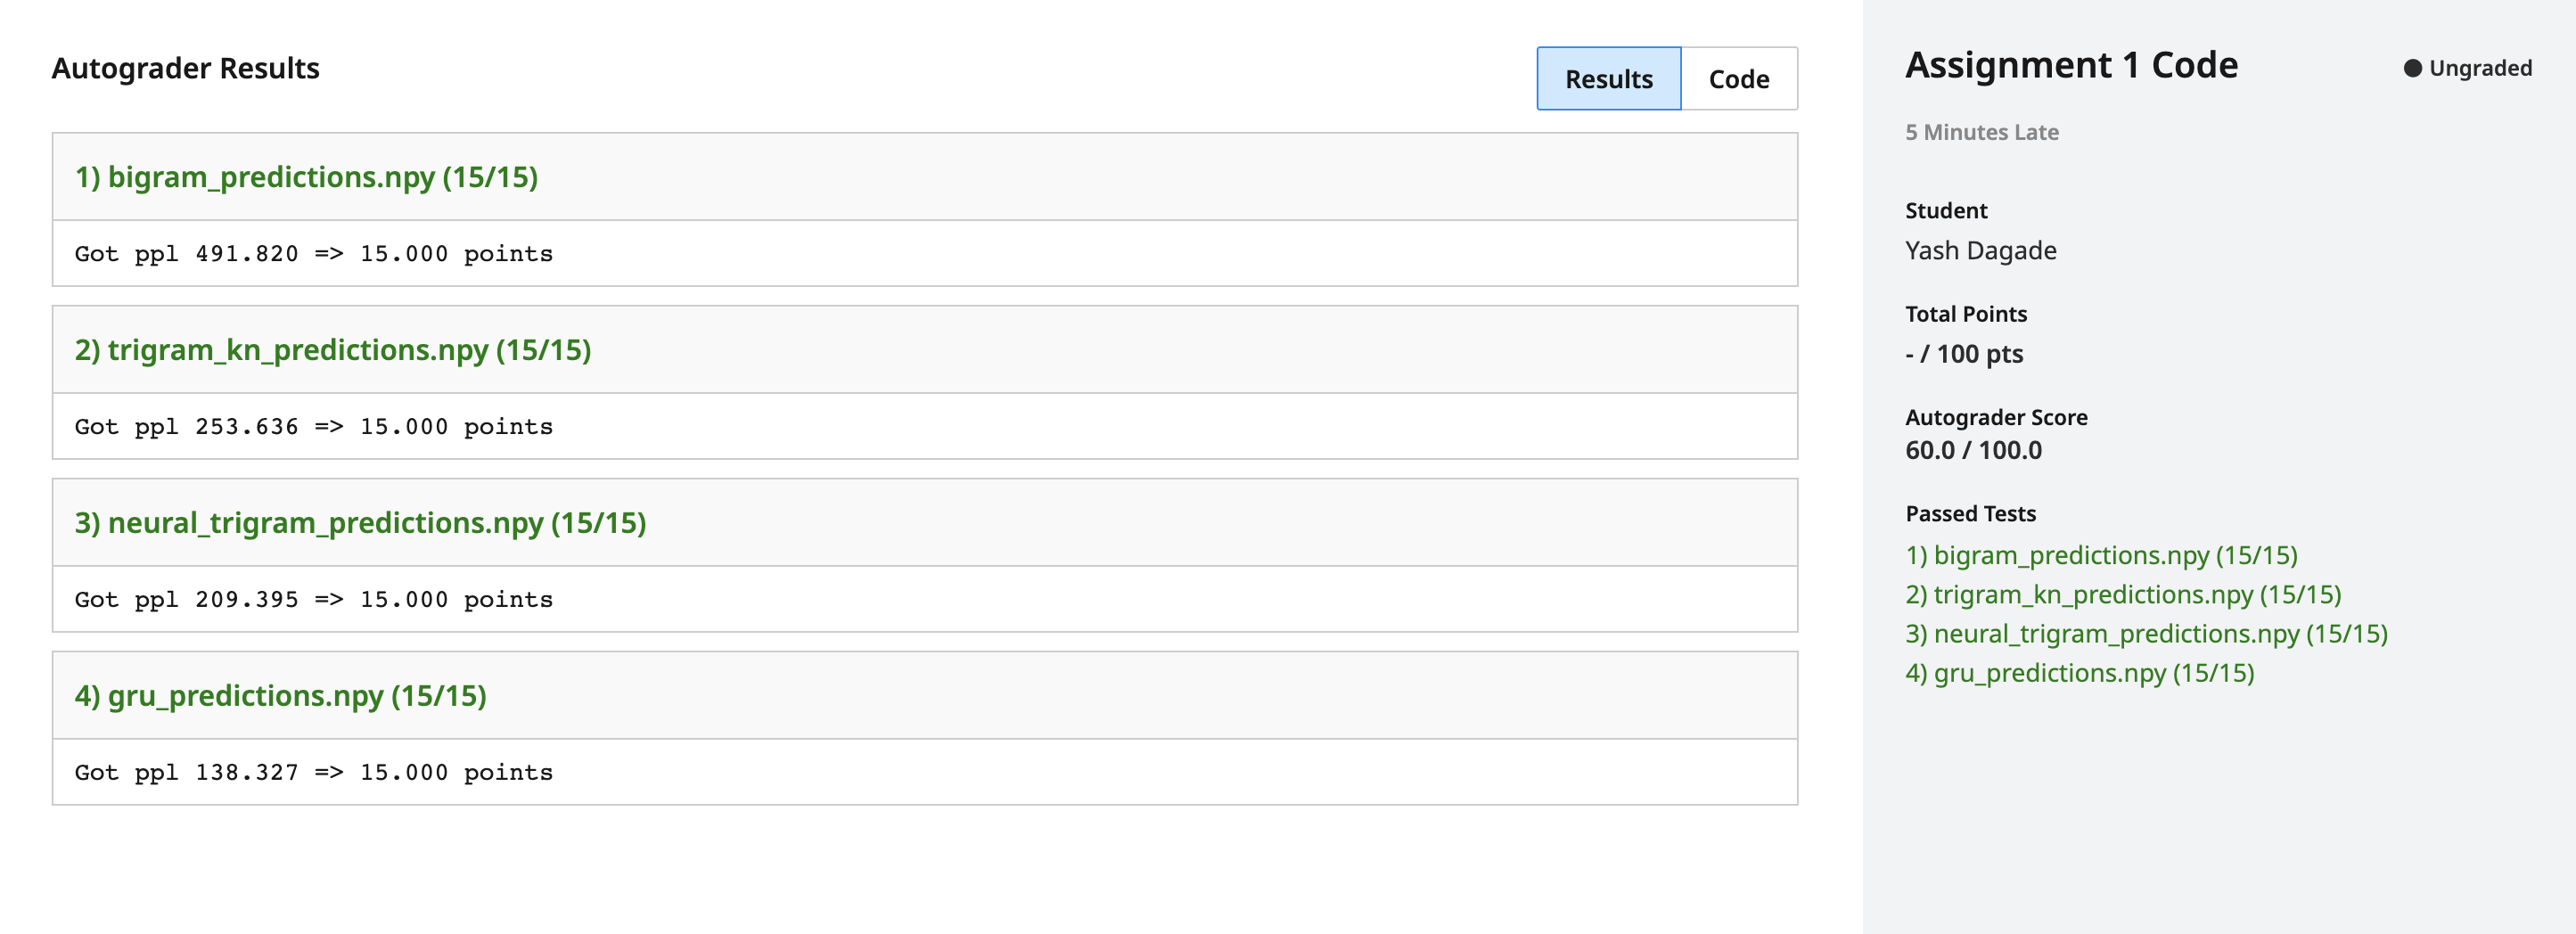

### Submission

Upload a submission with the following files to Gradescope:
* proj_1.ipynb (rename to match this exactly)
* gru_predictions.npy (this should also include all improvements from your exploration)
* neural_trigram_predictions.npy
* trigram_kn_predictions.npy
* bigram_predictions.npy
* report.pdf

You can upload files individually or as part of a zip file, but if using a zip file be sure you are zipping the files directly and not a folder that contains them.

Be sure to check the output of the autograder after it runs.  It should confirm that no files are missing and that the output files have the correct format.  Note that the test set perplexities shown by the autograder are on a different scale from your validation set perplexities due to selecting different text and truncating the distribution.  Don't worry if the values seem worse. We will compare your perplexity on the test set to our model's perplexity and assign a score based on that.